# Using text and neural network features

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/decision_forests/tutorials/intermediate_colab"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/decision-forests/blob/main/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/decision-forests/documentation/tutorials/intermediate_colab.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/universal-sentence-encoder/4"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>


Welcome to the **Intermediate Colab** for **TensorFlow Decision Forests** (**TF-DF**).
In this colab, you will learn about some more advanced capabilities of **TF-DF**, including how to deal with natural language features.

This colab assumes you are familiar with the concepts presented the [Beginner colab](beginner_colab.ipynb), notably about the installation about TF-DF.

In this colab, you will:

1. Train a Random Forest that consumes text features natively as categorical sets.

1. Train a Random Forest that consumes text features using a [TensorFlow Hub](https://www.tensorflow.org/hub) module. In this setting (transfer learning), the module is already pre-trained on a large text corpus.

1. Train a Gradient Boosted Decision Trees (GBDT) and a Neural Network together. The GBDT will consume the output of the Neural Network.

## Setup

In [11]:
# Install TensorFlow Dececision Forests
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.0 MB 15.0 MB/s 


[Wurlitzer](https://pypi.org/project/wurlitzer/) is needed to display the detailed training logs in Colabs (when using `verbose=2` in the model constructor).

In [12]:
!pip install wurlitzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the necessary libraries.

In [13]:
import tensorflow_decision_forests as tfdf

import os
import re
import string
import numpy as np
import pandas as pd
import tensorflow as tf
import math
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

The hidden code cell limits the output height in colab.

In [14]:
#@title

from IPython.core.magic import register_line_magic
from IPython.display import Javascript
from IPython.display import display as ipy_display

# Some of the model training logs can cover the full
# screen if not compressed to a smaller viewport.
# This magic allows setting a max height for a cell.
@register_line_magic
def set_cell_height(size):
  ipy_display(
      Javascript("google.colab.output.setIframeHeight(0, true, {maxHeight: " +
                 str(size) + "})"))

## Use raw text as features

TF-DF can consume [categorical-set](https://arxiv.org/pdf/2009.09991.pdf) features natively. Categorical-sets represent text features as bags of words (or n-grams).

For example: `"The little blue dog" ` → `{"the", "little", "blue", "dog"}`

In this example, you'll will train a Random Forest on the [Threat Intelligence Reports](https://github.com/threatDataset) dataset. The objective of this dataset is to classify reports into 12 threat actors. You'll will use the multiclass classification version of the dataset.

**Note:** Categorical-set features can be expensive to train. In this colab, we will train a small Random Forest with 1000 trees.

In [19]:
# Load the dataset

url = 'https://github.com/eyalmazuz/AttackAttributionDataset/archive/refs/heads/master.zip' 

dataset = tf.keras.utils.get_file('master.zip', url, extract=True, cache_dir='.', cache_subdir='')


# Display the first 3 examples of the test fold.
# for example in train_ds.take(1):
#   print({attr_name: attr_tensor.numpy() for attr_name, attr_tensor in example.items()})

1248841/1248841 [==============================] - 0s 0us/step


In [20]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 5
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'AttackAttributionDataset-master',
    batch_size=batch_size,
    validation_split=0.15,
    subset='validation',
    seed=seed)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


Found 238 files belonging to 12 classes.
Using 203 files for training.
Found 238 files belonging to 12 classes.
Using 35 files for validation.



**Details:** Some decision forest learning algorithms do not need a validation dataset (e.g. Random Forests) while others do (e.g. Gradient Boosted Trees in some cases). Since each learning algorithm under TF-DF can use validation data differently, TF-DF handles train/validation splits internally. As a result, when you have a training and validation sets, they can always be concatenated as input to the learning algorithm.

In [27]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : tf.strings.split(example["sentence"])}, label


# train_ds = all_ds["train"].batch(100).map(prepare_dataset)
# test_ds = all_ds["validation"].batch(100).map(prepare_dataset)

Finaly, train and evaluate the model as usual. TF-DF  automatically detects multi-valued categorical features as categorical-set.


In [28]:
%set_cell_height 300

# Specify the model.
model_1 = tfdf.keras.RandomForestModel(num_trees=15000, verbose=2, check_dataset=False)
# Train the model.
history = model_1.fit(x=train_ds)

print(history.history.items())


<IPython.core.display.Javascript object>

Use 8 thread(s) for training
Use /tmp/tmphwsnyaso as temporary training directory
Reading training dataset...
Training tensor examples:
Features: Tensor("data:0", shape=(None,), dtype=string)
Label: Tensor("data_1:0", shape=(None,), dtype=int32)
Weights: None
Normalized tensor features:
 {'data:0': SemanticTensor(semantic=<Semantic.CATEGORICAL: 2>, tensor=<tf.Tensor 'data:0' shape=(None,) dtype=string>)}
Training dataset read in 0:00:00.165552. Found 203 examples.
Training model...


[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 41
[INFO kernel.cc:423] Number of examples: 203
[INFO data_spec_inference.cc:303] 203 item(s) have been pruned (i.e. they are considered out of dictionary) for the column data:0 (0 item(s) left) because min_value_count=5 and max_number_of_unique_values=2000
[INFO kernel.cc:836] Training dataset:
Number of records: 203
Number of columns: 2

Number of columns by type:
	CATEGORICAL: 2 (100%)

Columns:

CATEGORICAL: 2 (100%)
	0: "data:0" CATEGORICAL has-dict vocab-size:1 num-oods:203 (100%)
	1: "__LABEL" CATEGORICAL integerized vocab-size:13 no-ood-item

Terminology:
	nas: Number of non-available (i.e. missing) values.
	ood: Out of dictionary.
	manually-defined: Attribute which type is manually defined by the user i.e. the type was not automatically inferred.
	tokenized: The attribute value is obtained through tokenization.
	has-dict: The attribute is a

Model trained in 0:00:00.596218
Compiling model...
Model compiled.
dict_items([('num_examples', [203]), ('accuracy', [0.24630541871921183]), ('loss', [22.994849424671585])])


In [29]:
model_gb_1 = tfdf.keras.GradientBoostedTreesModel(num_trees=15000, check_dataset=False)


history_gb = model_gb_1.fit(x=train_ds)

print(history_gb.history.items())

Use /tmp/tmpjh08qg82 as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.127581. Found 203 examples.
Training model...
Model trained in 0:00:00.063455
Compiling model...
Model compiled.
dict_items([('accuracy', [0.20000000298023224]), ('loss', [2.440039873123169])])


In [30]:
model_dgb_1 = tfdf.keras.DistributedGradientBoostedTreesModel( check_dataset=False)

# Use distributed gradientboosted trees for large distributed datasets
history_dgb = model_dgb_1.fit(x=train_ds)

print(history_gb.history.items())

Use /tmp/tmp9urz4v0h as temporary training directory
Reading training dataset...


Training dataset read in 0:00:00.129756. Found 203 examples.
Training model...


UnknownError: ignored

In the previous logs, note that `sentence` is a `CATEGORICAL_SET` feature.

The model is evaluated as usual:

In [31]:
model_1.compile(metrics=["accuracy"])
evaluation = model_1.evaluate(test_ds)
print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
model_1.make_inspector().evaluation()




7/7 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.1429
loss: 0.0
Accuracy: 0.1428571492433548


Evaluation(num_examples=203, accuracy=0.24630541871921183, loss=22.994849424671585, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [32]:
model_gb_1.compile(metrics=["accuracy"])
evaluation = model_gb_1.evaluate(test_ds)
print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
model_gb_1.make_inspector().evaluation()

7/7 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.1429
loss: 0.0
Accuracy: 0.1428571492433548


Evaluation(num_examples=None, accuracy=0.20000000298023224, loss=2.434854030609131, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)

In [33]:
tfdf.model_plotter.plot_model_in_colab(model_1, tree_idx=3, max_depth=300)


In [34]:
tfdf.model_plotter.plot_model_in_colab(model_gb_1, tree_idx=0, max_depth=300)


In [35]:
model_1.make_inspector().variable_importances()

{'NUM_NODES': [],
 'SUM_SCORE': [],
 'NUM_AS_ROOT': [],
 'MEAN_MIN_DEPTH': [("data:0" (4; #0), 0.0), ("__LABEL" (4; #1), 0.0)]}

The training logs looks are follow:

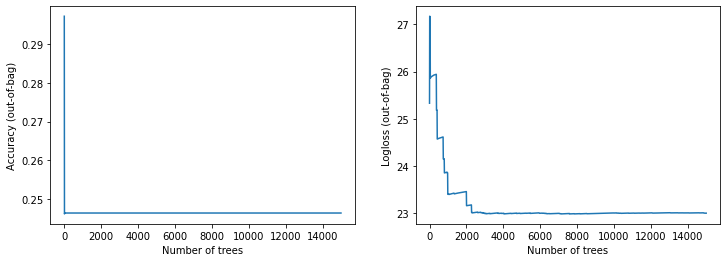

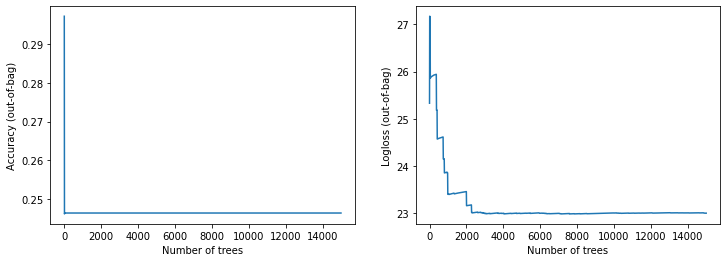

In [36]:
import matplotlib.pyplot as plt
# Plotting random forrest results
logs = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

# plotting gradient boosted results
logs_gb = model_1.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()
pass

More trees would probably be beneficial (I am sure of it because I tried :p).

## Use a pretrained text embedding

The previous example trained a Random Forest using raw text features. This example will use a pre-trained TF-Hub embedding to convert text features into a dense embedding, and then train a Random Forest on top of it. In this situation, the Random Forest will only "see" the numerical output of the embedding (i.e. it will not see the raw text). 

In this experiment,  will use the [Universal-Sentence-Encoder](https://tfhub.dev/google/universal-sentence-encoder/4). Different pre-trained embeddings might be suited for different types of text (e.g. different language, different task) but also for other type of structured features (e.g. images).

**Note:** This embedding is large (1GB) and therefore the final model will be slow to run (compared to classical decision tree inference).

The embedding module can be applied in one of two places:

1. During the dataset preparation.
2. In the pre-processing stage of the model.

The second option is often preferable: Packaging the embedding in the model makes the model easier to use (and harder to misuse).

First install TF-Hub:

In [37]:
!pip install --upgrade tensorflow-hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Unlike before, you don't need to tokenize the text.

In [38]:
def prepare_dataset(example):
  label = (example["label"] + 1) // 2
  return {"sentence" : example["sentence"]}, label

# train_ds = all_ds["train"].batch(100).map(prepare_dataset)
# test_ds = all_ds["validation"].batch(100).map(prepare_dataset)


In [39]:
%set_cell_height 300

import tensorflow_hub as hub
# NNLM (https://tfhub.dev/google/nnlm-en-dim128/2) is also a good choice.
hub_url = "http://tfhub.dev/google/universal-sentence-encoder/4"
embedding = hub.KerasLayer(hub_url)

inputs = tf.keras.layers.Input(shape=(), name="input", dtype=tf.string)
embedded_inputs = embedding(inputs)

raw_inputs = {"input": inputs}
processed_inputs = {"embedded_reports": embedded_inputs}
preprocessor = tf.keras.Model(inputs=raw_inputs, outputs=processed_inputs)

model_2 = tfdf.keras.RandomForestModel(
    preprocessing=preprocessor,
    check_dataset=False,
    num_trees=15000)


<IPython.core.display.Javascript object>

Use /tmp/tmpst0oz3_w as temporary training directory


In [40]:
model_gb_2 = tfdf.keras.GradientBoostedTreesModel(
    preprocessing=preprocessor,
    check_dataset=False,
    num_trees=15000)

Use /tmp/tmpznge3sto as temporary training directory


In [41]:
history = model_2.fit(x=train_ds)
print(history.history.items())

Reading training dataset...
Training dataset read in 0:00:10.568870. Found 203 examples.
Training model...
Model trained in 0:00:36.442057
Compiling model...


Model compiled.
dict_items([('num_examples', [203]), ('accuracy', [0.4088669950738916]), ('loss', [1.89739379719854])])


In [42]:
history_gb = model_gb_2.fit(x=train_ds)
print(history.history.items())

Reading training dataset...
Training dataset read in 0:00:06.525223. Found 203 examples.
Training model...
Model trained in 0:00:02.611699
Compiling model...


Model compiled.
dict_items([('num_examples', [203]), ('accuracy', [0.4088669950738916]), ('loss', [1.89739379719854])])


In [43]:
model_2.summary()


Streaming output truncated to the last 5000 lines.
  106. "embedded_reports.321" 13885.191654 ##
  107.  "embedded_reports.81" 13793.999358 ##
  108. "embedded_reports.377" 13772.928771 ##
  109.  "embedded_reports.12" 13750.965713 ##
  110. "embedded_reports.485" 13683.244504 ##
  111. "embedded_reports.306" 13668.504846 ##
  112. "embedded_reports.158" 13641.369281 ##
  113. "embedded_reports.151" 13529.989142 ##
  114. "embedded_reports.501" 13501.807071 ##
  115. "embedded_reports.504" 13484.001943 ##
  116. "embedded_reports.244" 13432.120569 ##
  117. "embedded_reports.472" 13416.656452 ##
  118.  "embedded_reports.22" 13410.220649 ##
  119.  "embedded_reports.61" 13393.352204 ##
  120.  "embedded_reports.53" 13373.628571 ##
  121. "embedded_reports.438" 13368.662675 ##
  122. "embedded_reports.395" 13344.292129 ##
  123. "embedded_reports.296" 13281.431557 ##
  124.  "embedded_reports.91" 13058.395233 ##
  125. "embedded_reports.473" 13028.315238 ##
  126. "embedded_reports.398"

In [44]:
model_2.compile(metrics=["accuracy"])
evaluation = model_2.evaluate(test_ds)
print(evaluation)

print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

7/7 [==============================] - 2s 37ms/step - loss: 0.0000e+00 - accuracy: 0.2571
[0.0, 0.2571428716182709]
loss: 0.0
Accuracy: 0.2571428716182709


In [45]:
model_gb_2.compile(metrics=["accuracy"])
evaluation = model_gb_2.evaluate(test_ds)
print(evaluation)

print(f"loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")

7/7 [==============================] - 2s 27ms/step - loss: 0.0000e+00 - accuracy: 0.2286
[0.0, 0.22857142984867096]
loss: 0.0
Accuracy: 0.22857142984867096


Note that categorical sets represent text differently from a dense embedding, so it may be useful to use both strategies jointly.

## Train a decision tree and neural network together

The previous example used a pre-trained Neural Network (NN) to 
process the text features before passing them to the Random Forest. This example will train both the Neural Network and the Random Forest from scratch.


TF-DF's Decision Forests do not back-propagate gradients ([although this is the subject of ongoing research](https://arxiv.org/abs/2007.14761)). Therefore, the training happens in two stages:

1. Train the neural-network as a standard classification task:

```
example → [Normalize] → [Neural Network*] → [classification head] → prediction
*: Training.
```

2. Replace the Neural Network's head (the last layer and the soft-max) with a Random Forest. Train the Random Forest as usual:

```
example → [Normalize] → [Neural Network] → [Random Forest*] → prediction
*: Training.
```



### Prepare the dataset



### Build the models

Next create the neural network model using [Keras' functional style](https://www.tensorflow.org/guide/keras/functional). 

Bring back that Functional model from BERT

In [46]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 100000
sequence_length = 1000

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

Build the body of the neural network:

In [47]:
embedding_dim=336

nn_model = Sequential([
  vectorize_layer,
  Embedding(vocab_size, embedding_dim, name="embedding"),
  GlobalAveragePooling1D(),
  Dense(320, activation="tanh"),
  Dense(118, activation="relu"),
  tf.keras.layers.Dropout(0.25),
  Dense(112, activation="tanh"),
  tf.keras.layers.Dropout(0.15),  
  Dense(94, activation='tanh'),
  Dense(len(class_names))
])

# y = tf.keras.layers.Concatenate()(nn_processed_inputs)
# y = tf.keras.layers.Dense(16, activation=tf.nn.relu6)(nn_raw_inputs)
# last_layer = tf.keras.layers.Dense(8, activation=tf.nn.relu, name="last")(y)

# "3" for the three label classes. If it were a binary classification, the
# output dim would be 1.
# classification_output = tf.keras.layers.Dense(12)(y)

# nn_model = tf.keras.models.Model(nn_raw_inputs, classification_output)

This `nn_model` directly produces classification logits. 

Next create a decision forest model. This will operate on the high level features that the neural network extracts in the last layer before that classification head.

### Train and evaluate the models

The model will be trained in two stages. First train the neural network with its own classification head:

In [48]:
%set_cell_height 300

nn_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"])

nn_model.fit(x=train_ds, validation_data=test_ds, epochs=30)
nn_model.summary()

<IPython.core.display.Javascript object>

Epoch 1/30
41/41 [==============================] - 1s 15ms/step - loss: 2.4072 - accuracy: 0.2118 - val_loss: 2.3992 - val_accuracy: 0.2286
Epoch 2/30
41/41 [==============================] - 0s 9ms/step - loss: 2.1006 - accuracy: 0.3399 - val_loss: 2.2874 - val_accuracy: 0.2000
Epoch 3/30
41/41 [==============================] - 0s 9ms/step - loss: 1.8534 - accuracy: 0.3892 - val_loss: 2.2741 - val_accuracy: 0.2000
Epoch 4/30
41/41 [==============================] - 0s 9ms/step - loss: 1.4698 - accuracy: 0.5222 - val_loss: 2.0759 - val_accuracy: 0.3714
Epoch 5/30
41/41 [==============================] - 0s 10ms/step - loss: 1.2522 - accuracy: 0.5862 - val_loss: 2.8138 - val_accuracy: 0.2857
Epoch 6/30
41/41 [==============================] - 0s 9ms/step - loss: 1.1766 - accuracy: 0.5813 - val_loss: 2.2928 - val_accuracy: 0.3143
Epoch 7/30
41/41 [==============================] - 0s 10ms/step - loss: 1.1755 - accuracy: 0.6108 - val_loss: 2.5833 - val_accuracy: 0.4000
Epoch 8/30
41/41 

The neural network layers are shared between the two models. So now that the neural network is trained the decision forest model will be fit to the trained output of the neural network layers:

In [49]:
# To reduce the risk of mistakes, group both the decision forest and the
# neural network in a single keras model.
df_and_nn_model = tfdf.keras.RandomForestModel(preprocessing=nn_model, check_dataset=False)
gdb_df_and_nn_model = tfdf.keras.GradientBoostedTreesModel(preprocessing=nn_model, check_dataset=False)

Use /tmp/tmp466deefe as temporary training directory
Use /tmp/tmpdohzbkzn as temporary training directory


In [50]:
%set_cell_height 300

history = df_and_nn_model.fit(x=train_ds)

print(history.history)

<IPython.core.display.Javascript object>

Reading training dataset...
Training dataset read in 0:00:00.479802. Found 203 examples.
Training model...
Model trained in 0:00:00.082414
Compiling model...
Model compiled.
{'num_examples': [203], 'accuracy': [0.9802955665024631], 'loss': [0.1628703939145789]}


In [51]:
%set_cell_height 300

history_gdb = gdb_df_and_nn_model.fit(x=train_ds)

print(history.history)

<IPython.core.display.Javascript object>

Reading training dataset...
Training dataset read in 0:00:00.458798. Found 203 examples.
Training model...
Model trained in 0:00:00.403029
Compiling model...
Model compiled.


{'num_examples': [203], 'accuracy': [0.9802955665024631], 'loss': [0.1628703939145789]}


Now evaluate the composed model:

In [52]:
df_and_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", df_and_nn_model.evaluate(test_ds))

7/7 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.5143
Evaluation: [0.0, 0.5142857432365417]


In [53]:
gdb_df_and_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", gdb_df_and_nn_model.evaluate(test_ds))

7/7 [==============================] - 0s 5ms/step - loss: 0.0000e+00 - accuracy: 0.4571
Evaluation: [0.0, 0.4571428596973419]


Compare it to the Neural Network alone:

In [54]:
print("Evaluation :", nn_model.evaluate(test_ds))

7/7 [==============================] - 0s 4ms/step - loss: 3.0133 - accuracy: 0.4571
Evaluation : [3.013303279876709, 0.4571428596973419]


# NN with BERT Encoder and DF trees

In [1]:
!pip install -q tf-models-official==2.7.0


     |████████████████████████████████| 1.8 MB 13.3 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 67.3 MB/s 
     |████████████████████████████████| 238 kB 92.8 MB/s 
     |████████████████████████████████| 352 kB 88.7 MB/s 
     |████████████████████████████████| 4.6 MB 75.7 MB/s 
     |████████████████████████████████| 116 kB 86.2 MB/s 
     |████████████████████████████████| 1.3 MB 93.6 MB/s 
     |████████████████████████████████| 99 kB 9.6 MB/s 
     |████████████████████████████████| 511.8 MB 5.6 kB/s 
     |████████████████████████████████| 511.7 MB 5.3 kB/s 
     |████████████████████████████████| 511.7 MB 3.6 kB/s 
     |████████████████████████████████| 4.9 MB 80.2 MB/s 


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.9.*"

     |████████████████████████████████| 5.8 MB 12.1 MB/s 
     |████████████████████████████████| 438 kB 65.9 MB/s 
     |████████████████████████████████| 1.6 MB 79.3 MB/s 


In [7]:
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow_hub as hub
import tensorflow_text as text

import tensorflow as tf


In [4]:
bert_model_name = 'bert_en_wwm_uncased_L-24_H-1024_A-16'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_uncased_L-24_H-1024_A-16", "bert_en_wwm_uncased_L-24_H-1024_A-16", "bert_en_cased_L-12_H-768_A-12", "bert_en_cased_L-24_H-1024_A-16", "bert_en_wwm_cased_L-24_H-1024_A-16", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "albert_en_large", "albert_en_xlarge", "albert_en_xxlarge", "electra_small", "electra_base", "electra_large", "experts_pubmed", "experts_wiki_books", "experts_wiki_books_mnli", "experts_wiki_books_qnli", "experts_wiki_books_qqp", "experts_wiki_books_sst2", "experts_wiki_books_squad2", "talking-heads_base", "talking-heads_large"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_wwm_cased_L-24_H-1024_A-16/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_large/2',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_xlarge/2',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_xxlarge/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'electra_large':
        'https://tfhub.dev/google/electra_large/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_pubmed_squad2':
        'https://tfhub.dev/google/experts/bert/pubmed/squad2/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'experts_wiki_books_mnli':
        'https://tfhub.dev/google/experts/bert/wiki_books/mnli/2',
    'experts_wiki_books_qnli':
        'https://tfhub.dev/google/experts/bert/wiki_books/qnli/2',
    'experts_wiki_books_qqp':
        'https://tfhub.dev/google/experts/bert/wiki_books/qqp/2',
    'experts_wiki_books_sst2':
        'https://tfhub.dev/google/experts/bert/wiki_books/sst2/2',
    'experts_wiki_books_squad2':
        'https://tfhub.dev/google/experts/bert/wiki_books/squad2/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_wwm_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'bert_en_wwm_uncased_L-24_H-1024_A-16':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_large':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'albert_en_xxlarge':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed_squad2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_mnli':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_qnli':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_qqp':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_sst2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books_squad2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_large':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print('BERT model selected           :', tfhub_handle_encoder)
print('Preprocessing model auto-selected:', tfhub_handle_preprocess)

BERT model selected           : https://tfhub.dev/tensorflow/bert_en_wwm_uncased_L-24_H-1024_A-16/3
Preprocessing model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


# Build The Model

In [8]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dense(562, activation="relu")(net)
  net = tf.keras.layers.Dense(272, activation="tanh")(net)
  net = tf.keras.layers.Dropout(0.2)(net)
  net = tf.keras.layers.Dense(172, activation="tanh")(net)
  net = tf.keras.layers.Dropout(0.25)(net)
  net = tf.keras.layers.Dense(94, activation="tanh")(net)
  net = tf.keras.layers.Dense(len(class_names), activation="softmax", name='outputs')(net)
  return tf.keras.Model(text_input, net)

In [22]:
bert_nn_model = build_classifier_model()

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = 900
num_warmup_steps = 121

init_lr = 1e-4
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
bert_nn_model.compile(
  optimizer=optimizer,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=["accuracy"])

bert_nn_model.fit(x=train_ds, validation_data=test_ds, epochs=20)
bert_nn_model.summary()

Epoch 1/20
41/41 [==============================] - 45s 243ms/step - loss: 2.4954 - accuracy: 0.1281 - val_loss: 2.3364 - val_accuracy: 0.2000
Epoch 2/20
41/41 [==============================] - 9s 209ms/step - loss: 2.0441 - accuracy: 0.3793 - val_loss: 1.9244 - val_accuracy: 0.3714
Epoch 3/20
41/41 [==============================] - 9s 209ms/step - loss: 1.7547 - accuracy: 0.4877 - val_loss: 2.7395 - val_accuracy: 0.1429
Epoch 4/20
41/41 [==============================] - 9s 210ms/step - loss: 2.5296 - accuracy: 0.1823 - val_loss: 2.4700 - val_accuracy: 0.1429
Epoch 5/20
41/41 [==============================] - 9s 211ms/step - loss: 2.5240 - accuracy: 0.1823 - val_loss: 2.6254 - val_accuracy: 0.1429
Epoch 6/20
41/41 [==============================] - 9s 209ms/step - loss: 2.4464 - accuracy: 0.1970 - val_loss: 2.5407 - val_accuracy: 0.1429
Epoch 7/20
41/41 [==============================] - 9s 210ms/step - loss: 2.4762 - accuracy: 0.2118 - val_loss: 2.5780 - val_accuracy: 0.1429
Epoch

In [23]:
df_and_bert_nn_model = tfdf.keras.RandomForestModel(preprocessing=bert_nn_model, check_dataset=False)
gdb_df_and_bert_nn_model = tfdf.keras.GradientBoostedTreesModel(preprocessing=bert_nn_model, check_dataset=False)

Use /tmp/tmpchs6cx4m as temporary training directory
Use /tmp/tmp3b2nqqih as temporary training directory


In [25]:
history_gdb = df_and_bert_nn_model.fit(x=train_ds)

print(history_gdb.history)

Reading training dataset...
Training dataset read in 0:00:02.709258. Found 203 examples.
Training model...
Model trained in 0:00:00.120937
Compiling model...
Model compiled.
{'num_examples': [203], 'accuracy': [0.28078817733990147], 'loss': [3.349989722881998]}


In [26]:
history_gdb = gdb_df_and_bert_nn_model.fit(x=train_ds)

print(history_gdb.history)

Reading training dataset...
Training dataset read in 0:00:06.132076. Found 203 examples.
Training model...
Model trained in 0:00:00.083896
Compiling model...
Model compiled.
{'accuracy': [0.07999999821186066], 'loss': [2.535151481628418]}


In [28]:
df_and_bert_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", df_and_bert_nn_model.evaluate(test_ds))

7/7 [==============================] - 2s 70ms/step - loss: 0.0000e+00 - accuracy: 0.1714
Evaluation: [0.0, 0.17142857611179352]


In [29]:
gdb_df_and_bert_nn_model.compile(metrics=["accuracy"])
print("Evaluation:", gdb_df_and_bert_nn_model.evaluate(test_ds))

7/7 [==============================] - 2s 68ms/step - loss: 0.0000e+00 - accuracy: 0.2571
Evaluation: [0.0, 0.2571428716182709]
